## Create and test ion channel model

In [1]:
from experiments.ical_markov import (dias_iv,
                                     rao_inact,
                                     rao_rec)

In [2]:
from ionchannelABC.experiment import setup
from ionchannelABC import plot_sim_results

In [3]:
modelfile = 'models/ical_markov.mmt'
#modelfile = 'models/Korhonen2009_iCaL.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                dias_iv,
                                                rao_inact,
                                                rao_rec)

In [5]:
assert(len(observations)==len(summary_statistics(model({}))))

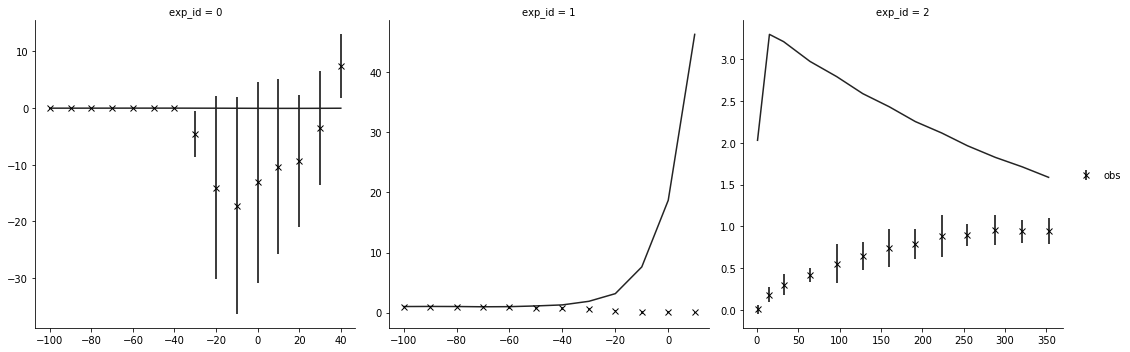

In [6]:
g = plot_sim_results(modelfile, dias_iv, rao_inact, rao_rec)

## Set limits and generate uniform initial priors

In [8]:
from pyabc import Distribution, RV
limits = {'ical.g_CaL': (0., 5.),
          'ical.E_CaL': (0., 50.),
          'log_ical.p_1': (-10., 5.),
          'ical.p_2': (1e-7, 0.8),
          'log_ical.p_3': (-15., 5.),
          'ical.p_4': (1e-7, 1.2),
          'log_ical.p_5': (-10., 5.),
          'ical.p_6': (1e-7, 0.8),
          'log_ical.p_7': (-10., 5.),
          'ical.p_8': (1e-7, 0.8)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

from pyabc import Distribution, RV
limits = {'ical.P_CaL': (0., 1e-2),
          'ical.gamma_Ca_o': (0., 1.),
          'log_ical.p_1': (-7., 3.),
          'ical.p_2': (1e-7, 0.4),
          'log_ical.p_3': (-7., 3.),
          'ical.p_4': (1e-7, 0.4),
          'log_ical.p_5': (-7., 3.),
          'ical.p_6': (1e-7, 0.4),
          'log_ical.p_7': (-7., 3.),
          'ical.p_8': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [9]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_ical.db"))

In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [12]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=4),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.8867610770175904, '1': 1.8867610770175904, '2': 1.8867610770175904, '3': 1.8867610770175904, '4': 1.8867610770175904, '5': 1.8867610770175904, '6': 1.8867610770175904, '7': 0.39816349969451226, '8': 0.10032466134034942, '9': 0.08494154660149587, '10': 0.09166353949801716, '11': 0.10529943793573877, '12': 0.1384916520676564, '13': 0.16128141759777695, '14': 0.2895734543232815, '15': 2.358451346271988, '16': 2.358451346271988, '17': 2.2794584219158174, '18': 1.4147282162925725, '19': 0.38344526580217353, '20': 0.5470628030521332, '21': 0.4186490615823911, '22': 0.5778429277938125, '23': 0.9769239053110288, '24': 0.506533055189962, '25': 0.7197629255048045, '26': 2.358451346271988, '27': 1.9314585329684408, '28': 1.1445680195368497, '29': 0.8352253115539181, '30': 1.2876390219789555, '31': 0.4478744424274633, '32': 0.630680337295815, '33': 0.4612438287685808, '34': 0.5722840097684249, '35': 0.4066228490459865, '36': 0.792393244294741, '37': 0.5830818

In [13]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [14]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0


In [10]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc_continued = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.8631167241717834, '1': 1.8631167241717834, '2': 1.8631167241717834, '3': 1.8631167241717834, '4': 1.8631167241717834, '5': 1.8631167241717834, '6': 1.8631167241717834, '7': 0.39317382803349854, '8': 0.09906742123678691, '9': 0.08387708331381294, '10': 0.09051483810843126, '11': 0.10397985534770209, '12': 0.13675611409860816, '13': 0.15926028477306253, '14': 0.2859446022061806, '15': 2.328895905214729, '16': 2.328895905214729, '17': 2.2461281752813442, '18': 1.3940420568450367, '19': 0.3778385281854085, '20': 0.5390636494045099, '21': 0.4125275739774083, '22': 0.5693937070867436, '23': 0.9626393215721591, '24': 0.499126527614958, '25': 0.7092385502432185, '26': 2.328895905214729, '27': 2.0022604724363955, '28': 1.1865247244067483, '29': 0.8658423664589795, '30': 1.3348403149575916, '31': 0.4642922834635106, '32': 0.6537993379384122, '33': 0.4781517546116745, '34': 0.5932623622033741, '35': 0.4215285205129242, '36': 0.8214401938200556, '37': 0.60445

In [11]:
abc_continued.load(db_path, 1)

1

In [24]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.001)

NameError: name 'abc_continued' is not defined

# Results analysis

In [15]:
from pyabc import History

In [16]:
history = History('sqlite:////scratch/cph211/tmp/hl1_ical.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-08-08 19:14:05.741700, end_time=None)>]

In [17]:
history.id = 1

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,ical.E_CaL,ical.g_CaL,ical.p_2,ical.p_4,ical.p_6,ical.p_8,log_ical.p_1,log_ical.p_3,log_ical.p_5,log_ical.p_7
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,33.350328,2.380486,0.205269,0.784666,0.161600,0.086969,-0.823470,-14.287257,-0.613623,-5.102048
std,0.289835,0.188916,0.002705,0.011584,0.002005,0.001130,0.051120,0.210319,0.024585,0.038503
min,32.323772,1.847903,0.197083,0.714604,0.154450,0.083066,-0.990508,-14.813698,-0.684014,-5.217840
25%,33.153708,2.287490,0.203449,0.778426,0.160227,0.086461,-0.853910,-14.436761,-0.630934,-5.121655
50%,33.349472,2.386682,0.205115,0.787071,0.161585,0.087062,-0.827408,-14.309574,-0.614642,-5.105247
75%,33.557053,2.466663,0.206850,0.793661,0.163001,0.087551,-0.800050,-14.161865,-0.596060,-5.085266
max,34.344658,3.126679,0.216567,0.799997,0.167921,0.090436,-0.640316,-13.286701,-0.539896,-4.965428


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


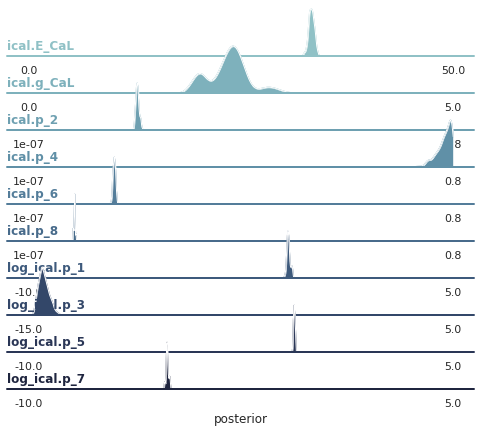

In [20]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

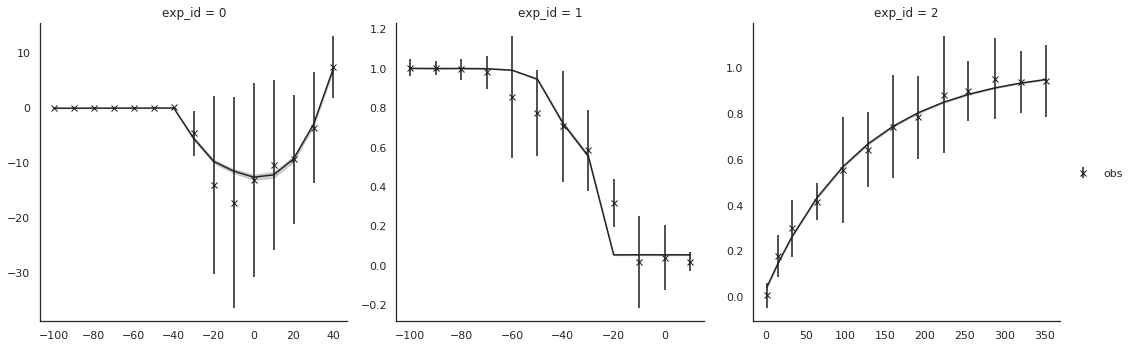

In [21]:
g = plot_sim_results(modelfile, dias_iv, rao_inact, rao_rec, df=df, w=w)

In [21]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [22]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

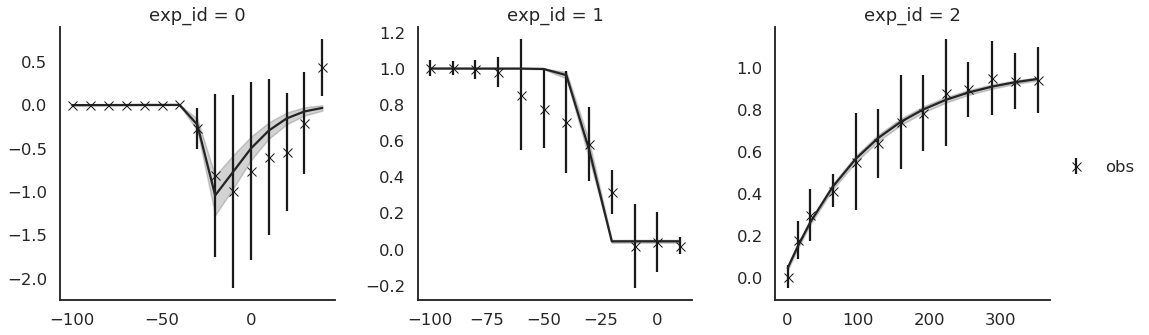

In [23]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]#, "time, ms","voltage, mV"]
#ylabels = ["normalised current density, pA/pF", "activation", "inactivation", "recovery"]#, "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [103]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

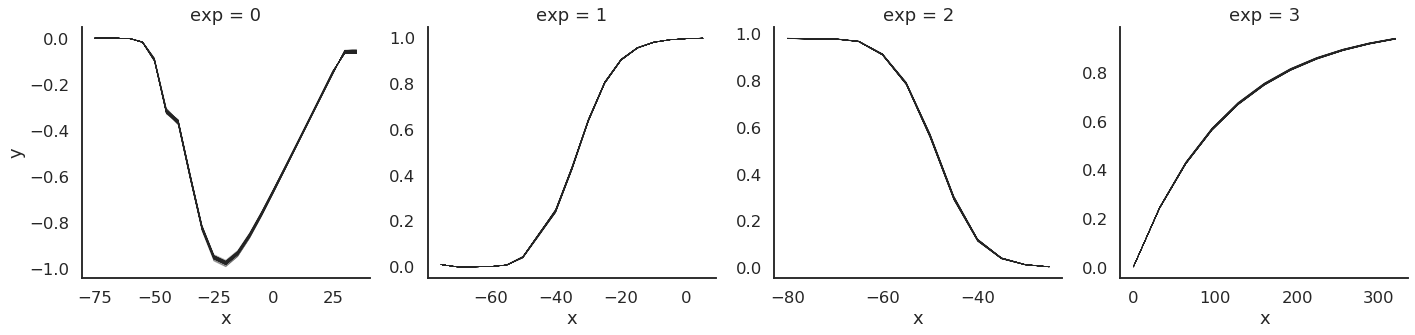

In [104]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
